# Functions

In [28]:
import time
import os
import shutil
import requests
import base64
from PyPDF2 import PdfReader
from unstructured.partition.pdf import partition_pdf
from pix2text import Pix2Text
import fitz
from IPython.display import display, Image
from langchain_community.chat_models import ChatSnowflakeCortex
from PIL import Image
import io
from snowflake.snowpark import Session
import snowflake.connector 
from snowflake.snowpark.types import StructType, StructField, StringType, IntegerType
from snowflake.cortex import complete
import uuid
import json
from langchain.text_splitter import RecursiveCharacterTextSplitter
from dotenv import load_dotenv
from io import BytesIO
from IPython.display import display 

### Fetching Papers using arXiv API 

In [29]:
# Function to fetch papers from arXiv API
def fetch_arxiv_papers(keyword, max_results=5):
    import arxiv  # Ensure arxiv library is installed
    search = arxiv.Search(
        query=keyword,
        max_results=max_results,
        sort_by=arxiv.SortCriterion.Relevance
    )
    papers = []
    for result in search.results():
        papers.append({
            "title": result.title,
            "authors": [author.name for author in result.authors],
            "summary": result.summary,
            "pdf_url": result.pdf_url
        })
    return papers

### Downloading and storing pdfs locally

In [30]:
# Function to clear the downloads folder
def clear_downloads_folder(output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)  # Remove all files and subdirectories
    os.makedirs(output_dir)  # Recreate the folder

# Function to download PDF
def download_pdf(pdf_url, output_dir="downloads"):
    os.makedirs(output_dir, exist_ok=True)
    pdf_name = pdf_url.split("/")[-1] + ".pdf"
    pdf_path = os.path.join(output_dir, pdf_name)

    # Save the PDF locally
    response = requests.get(pdf_url)
    if response.status_code == 200:
        with open(pdf_path, "wb") as f:
            f.write(response.content)
        return pdf_path
    else:
        print(f"Failed to download {pdf_url} with status code {response.status_code}")
        return None

### Extracting text along with mathematical expression from pdf 

In [31]:
# Function to extract text using fitz and Pix2Text
def extract_text_from_pdf_with_latex(pdf_file):
    math_extractor = Pix2Text()
    pdf_document = fitz.open(pdf_file)
    extracted_text = ""

    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        # Extract raw text
        text = page.get_text()
        extracted_text += f"Page {page_num + 1} Text:\n{text}\n"

        # Extract images for potential LaTeX expressions
        for img_index, img in enumerate(page.get_images(full=True)):
            xref = img[0]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image = Image.open(io.BytesIO(image_bytes))
            # Extract LaTeX code using Pix2Text
            latex_code = math_extractor(image)
            extracted_text += f"\nMath Expression (Image {img_index + 1}):\n{latex_code}\n"

    pdf_document.close()
    return extracted_text

### Extracting Images and Tables from the pdf

In [32]:
# Function to check if the image is valid or just lines or small elements
def is_valid_image(img):
    if len(img)>20000:
        return True
    else:
        return False

# Function to process PDF for tables and images using partition_pdf
def process_pdf_with_partition(file_path, output_path):
    chunks = partition_pdf(
        filename=file_path,
        infer_table_structure=True,
        strategy="hi_res",
        extract_image_block_types=["Image","Table"],
        image_output_dir_path=output_path,
        extract_image_block_to_payload=True,
    )

    tables = []
    images = []

    for chunk in chunks:
        if "Table" in str(type(chunk)):
            tables.append(chunk)
        elif "Image" in str(type(chunk)):
            if(is_valid_image(chunk.metadata.image_base64)):
                images.append(chunk.metadata.image_base64)

    return tables, images

### Displaying Image

In [34]:
def display_base64_img(base64_code):
    image_data = base64.b64decode(base64_code)
    image = Image.open(BytesIO(image_data))  # Open the image from a file-like object
    display(image) 

### Connecting to Snowflake 

In [35]:
def sendToMistral(prompt):
    # session = connect_to_snowflake()
    output = complete(
    "mistral-large2",
    prompt,
    session=session)  
    return output

In [36]:
# Chunk text using RecursiveCharacterTextSplitter
def chunk_text_with_langchain(text, chunk_size=500, chunk_overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    return splitter.split_text(text)

In [37]:
# Snowflake Table Creation
def create_snowflake_tables(cursor):
    # Papers table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS Papers (
            paper_id VARCHAR PRIMARY KEY,
            title VARCHAR,
            domain VARCHAR,
            keyword VARCHAR
        );
    """)

    # TextChunks table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS TextChunks (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            chunk_index INTEGER,
            chunk_text TEXT
        );
    """)

    # TextSummary table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS TextSummary (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            summary_index INTEGER,
            summary_text TEXT
        );
    """)

    # TablesContent table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS TablesContent (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            table_index INTEGER,
            table_content TEXT
        );
    """)

    # TableSummary table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS TableSummary (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            summary_index INTEGER,
            summary_text TEXT
        );
    """)

    # Images table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS Images (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            image_index INTEGER,
            image_metadata TEXT
        );
    """)

    # ImageSummary table
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS ImageSummary (
            id INTEGER AUTOINCREMENT PRIMARY KEY,
            paper_id VARCHAR REFERENCES Papers(paper_id),
            summary_index INTEGER,
            summary_text TEXT
        );
    """)


In [38]:
# Insert Data into Snowflake
def insert_data_into_snowflake(cursor, extracted_data, domain, keyword):
    for paper_id, content in extracted_data.items():
        # Check if the paper already exists
        cursor.execute("""
            SELECT COUNT(*) FROM Papers WHERE title = %s AND domain = %s AND keyword = %s
        """, (content["title"], domain, keyword))
        exists = cursor.fetchone()[0]

        if exists:
            print(f"Skipping existing paper: {content['title']}")
            continue

        # Insert into Papers table
        cursor.execute("""
            INSERT INTO Papers (paper_id, title, domain, keyword)
            VALUES (%s, %s, %s, %s)
        """, (paper_id, content["title"], domain, keyword))

        # Insert into TextChunks
        for i, chunk in enumerate(content["text_chunks"]):
            cursor.execute("""
                INSERT INTO TextChunks (paper_id, chunk_index, chunk_text)
                VALUES (%s, %s, %s)
            """, (paper_id, i, chunk))

        # Insert into TextSummary
        for i, summary in enumerate(content["textSummary"]):
            cursor.execute("""
                INSERT INTO TextSummary (paper_id, summary_index, summary_text)
                VALUES (%s, %s, %s)
            """, (paper_id, i, summary))

        # Insert into TablesContent
        for i, table in enumerate(content["tables"]):
            cursor.execute("""
                INSERT INTO TablesContent (paper_id, table_index, table_content)
                VALUES (%s, %s, %s)
            """, (paper_id, i, table))

        # Insert into TableSummary
        for i, summary in enumerate(content["tableSummary"]):
            cursor.execute("""
                INSERT INTO TableSummary (paper_id, summary_index, summary_text)
                VALUES (%s, %s, %s)
            """, (paper_id, i, summary))

        # Insert into Images
        for i, image in enumerate(content["images"]):
            cursor.execute("""
                INSERT INTO Images (paper_id, image_index, image_metadata)
                VALUES (%s, %s, %s)
            """, (paper_id, i, image))

        # Insert into ImageSummary
        for i, summary in enumerate(content["imageSummary"]):
            cursor.execute("""
                INSERT INTO ImageSummary (paper_id, summary_index, summary_text)
                VALUES (%s, %s, %s)
            """, (paper_id, i, summary))

        print(f"Inserted data for paper: {content['title']}")

In [ ]:
import json
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from langchain_community.chat_models import ChatSnowflakeCortex

# Initialize the embedding model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')  # Replace with your preferred model

# Dynamic Query Analysis
def get_indexed_keywords(session) -> list:
    """
    Dynamically fetch keywords or topics from the indexed dataset in Snowflake.
    """
    query = "SELECT DISTINCT keyword FROM Papers;"
    results = session.sql(query).collect()
    return [row['KEYWORD'] for row in results]

def classify_query(query: str, indexed_keywords: list) -> str:
    """
    Classify query as 'index' or 'web' based on cosine similarity with indexed keywords.
    """
    indexed_embeddings = embedding_model.encode(indexed_keywords)
    query_embedding = embedding_model.encode([query])
    
    # Compute similarity scores
    similarity_scores = cosine_similarity(query_embedding, indexed_embeddings)
    max_score = similarity_scores.max()

    # Classify based on threshold
    return "index" if max_score > 0.6 else "web"

# Cortex Query Builder
def build_cortex_query(query: str, content_type: str, limit: int = 5) -> str:
    """
    Builds a dynamic Cortex query for retrieving content.
    """
    if content_type == "text":
        source_types = ["text_chunk", "text_summary", "table_summary"]
    elif content_type == "image":
        source_types = ["image_summary"]
    else:
        raise ValueError("Invalid content type")

    # Use valid JSON syntax for filters
    source_filter = {"SOURCE_TYPE": {"$in": source_types}}
    cortex_query = f"""
    SELECT PARSE_JSON(
      SNOWFLAKE.CORTEX.SEARCH_PREVIEW(
          'RESEARCH_PAPERS_DB.PUBLIC.research_service',
          '{{
             "query": "{query}",
             "columns": ["PAPER_ID", "CONTENT", "SOURCE_TYPE"],
             "filter": {json.dumps(source_filter)},
             "limit": {limit}
          }}'
      )
    )['results'] AS results;
    """
    return cortex_query

# Self-Reflection Functions
def grade_documents(retrieved_docs: list, query: str) -> list:
    """
    Grade documents based on cosine similarity to the query.
    """
    query_embedding = embedding_model.encode([query])
    scores = []
    for doc in retrieved_docs:
        doc_embedding = embedding_model.encode([doc['CONTENT']])
        score = cosine_similarity(query_embedding, doc_embedding)[0][0]
        scores.append(score)
    return scores

def detect_hallucination(context: str, answer: str) -> bool:
    """
    Detect hallucinations by checking if the answer relies on the context.
    """
    prompt = f"""
    Context: {context}
    Generated Answer: {answer}
    Does the answer rely solely on the context? Answer 'Yes' or 'No':
    """
    response = chat.complete(prompt)
    return "No" in response

def rewrite_question(original_query: str, feedback: str) -> str:
    """
    Rewrite the query based on feedback.
    """
    prompt = f"Original Question: {original_query}\nFeedback: {feedback}\nRewritten Question:"
    return chat.complete(prompt)

# Main Query Handling
def handle_query(session, query: str):
    # Step 1: Query Analysis
    # indexed_keywords = get_indexed_keywords(session)
    # query_type = classify_query(query, indexed_keywords)
    query_type = "index"
    # Step 2: Routing
    if query_type == "index":
        # Step 2.1: Use Cortex for retrieval
        text_query = build_cortex_query(query, content_type="text", limit=5)
        text_results = session.sql(text_query).collect()
        
        # Combine retrieved text for context
        context = "\n".join([row['CONTENT'] for row in text_results])

        # Get relevant images
        image_query = build_cortex_query(query, content_type="image", limit=2)
        image_results = session.sql(image_query).collect()
        images = [row['CONTENT'] for row in image_results]

        # Step 2.2: Generate response using Mistral
        prompt = f"Context: {context}\nUser Query: {query}\nAnswer:"
        answer = chat.complete(prompt)

        # Step 2.3: Self-Reflection
        document_scores = grade_documents(text_results, query)
        if not detect_hallucination(context, answer) or min(document_scores) < 0.4:
            # Rewrite query and retry
            feedback = "The documents were not relevant or hallucinations were detected."
            rewritten_query = rewrite_question(query, feedback)
            return handle_query(session, rewritten_query)
        
        # Return answer and images
        return {"answer": answer, "images": images}
    else:
        # Step 3: Use Web Search
        web_search_prompt = f"""
        User Query: {query}
        Perform a web search and provide the best possible answer based on external information.
        Answer:
        """
        web_answer = chat.complete(web_search_prompt)
        return {"answer": web_answer}

# Example Execution
if __name__ == "__main__":
    # Example user query
    user_query = "Explain the ground state of Be and He atoms."

    # Handle the query
    result = handle_query(session, user_query)

    # Display the result
    # print("Answer:", result['answer'])
    # if 'images' in result:
    #     print("Images:", result['images'])


In [42]:
papers = fetch_arxiv_papers("electron", 3)

[WARNING 2025-01-22 00:46:35,883 _showwarnmsg:109] /var/folders/kf/zy5yhv3j6_xd7bjfyt4t2vth0000gn/T/ipykernel_34643/2185667634.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
 


In [46]:
print(papers[0])

{'title': 'Impact of Electron-Electron Cusp on Configuration Interaction Energies', 'authors': ['David Prendergast', 'M. Nolan', 'Claudia Filippi', 'Stephen Fahy', 'J. C. Greer'], 'summary': 'The effect of the electron-electron cusp on the convergence of configuration\ninteraction (CI) wave functions is examined. By analogy with the\npseudopotential approach for electron-ion interactions, an effective\nelectron-electron interaction is developed which closely reproduces the\nscattering of the Coulomb interaction but is smooth and finite at zero\nelectron-electron separation. The exact many-electron wave function for this\nsmooth effective interaction has no cusp at zero electron-electron separation.\nWe perform CI and quantum Monte Carlo calculations for He and Be atoms, both\nwith the Coulomb electron-electron interaction and with the smooth effective\nelectron-electron interaction. We find that convergence of the CI expansion of\nthe wave function for the smooth electron-electron inte

[WARNING 2025-01-22 00:24:29,199 _showwarnmsg:109] /var/folders/kf/zy5yhv3j6_xd7bjfyt4t2vth0000gn/T/ipykernel_34643/2185667634.py:10: DeprecationWarning: The 'Search.results' method is deprecated, use 'Client.results' instead
  for result in search.results():
 


Found 3 papers for keyword 'electron' in the database.
Processing: Impact of Electron-Electron Cusp on Configuration Interaction Energies
Saved PDF: downloads/0102536v1.pdf
Processing: Electron thermal conductivity owing to collisions between degenerate electrons
Saved PDF: downloads/0608371v1.pdf
Processing: Electron pairing: from metastable electron pair to bipolaron
Saved PDF: downloads/1802.06593v1.pdf
"[\n  {\n    \"content_summary\": \" The text discusses the development of an effective electron-electron interaction that mimics the scattering of the Coulomb interaction but is smooth and finite at zero electron-electron separation. This approach, analogous to the pseudopotential method for electron-ion interactions, eliminates the cusp in the many-electron wave function at zero separation. The effectiveness of this method is demonstrated through Configuration Interaction (CI) and quantum Monte Carlo calculations for He and Be atoms.\",\n    \"content_table\": \"rc (a.u.) 3 \u00d7 

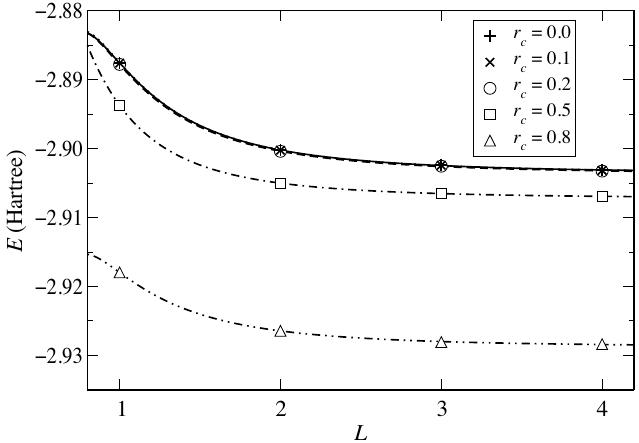

<class 'str'>


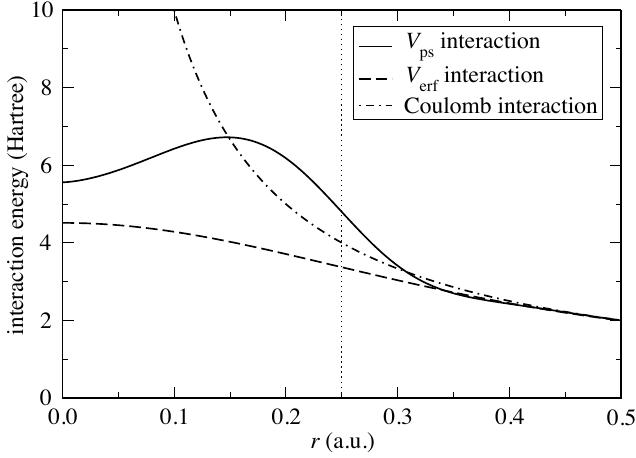

<class 'str'>


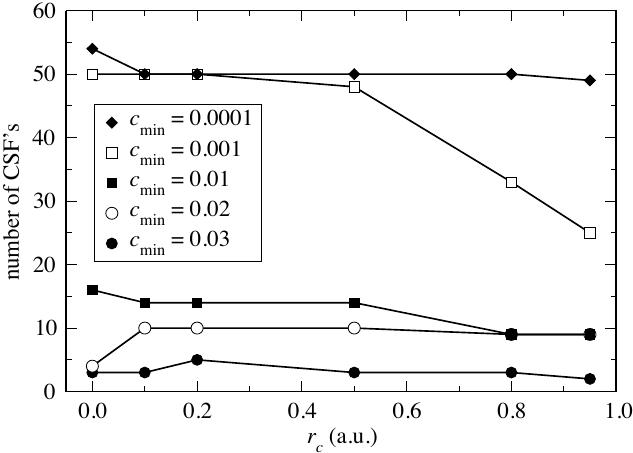

<class 'str'>


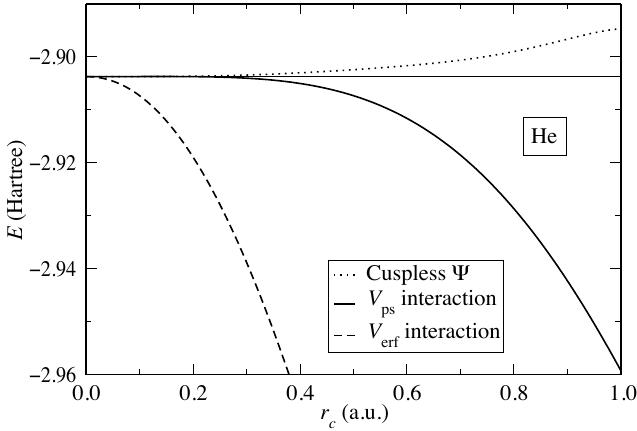

<class 'str'>


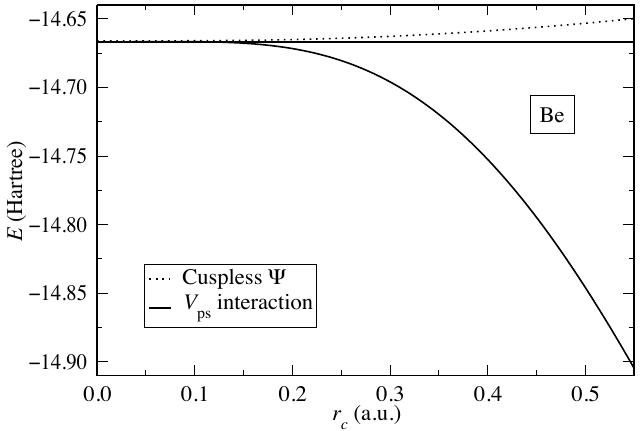

In [40]:
results_image=None
answer=None
if __name__ == "__main__":
    
    # Step 0: Load the environment variables and initialize the Snowflake Connection
    load_dotenv()
    snowflake_account = os.getenv("SNOWFLAKE_ACCOUNT")
    snowflake_user = os.getenv("SNOWFLAKE_USER")
    snowflake_password = os.getenv("SNOWFLAKE_PASSWORD")
    snowflake_role = os.getenv("SNOWFLAKE_ROLE")
    snowflake_warehouse = os.getenv("SNOWFLAKE_WAREHOUSE")
    snowflake_database = os.getenv("SNOWFLAKE_DATABASE")
    snowflake_schema = os.getenv("SNOWFLAKE_SCHEMA")
    snowflake_username=os.getenv("SNOWFLAKE_USERNAME")

    # Snowflake configuration
    snowflake_config = {
        "account": snowflake_account,
        "user": snowflake_user,
        "password": snowflake_password,
        "role": snowflake_role,
        "warehouse": snowflake_warehouse,
        "database": snowflake_database,
        "schema": snowflake_schema
    }

    session = Session.builder.configs(snowflake_config).create()
    
    # Snowflake connection details
    conn = snowflake.connector.connect(
        user=snowflake_user,
        password=snowflake_password,
        account=snowflake_account,
        role=snowflake_role,
        database=snowflake_database,
        warehouse=snowflake_warehouse,
        schema=snowflake_schema
    )
    
    cursor = conn.cursor()

    # Initialize the ChatSnowflakeCortex instance
    chat = ChatSnowflakeCortex(
        # Change the default cortex model and function
        model="mistral-large2",
        cortex_function="complete",

        # Change the default generation parameters
        temperature=0,
        max_tokens=10,
        top_p=0.95,

        # Specify your Snowflake Credentials
        account=snowflake_account,
        username=snowflake_username,
        password=snowflake_password,
        database=snowflake_database,
        schema=snowflake_schema,
        role=snowflake_role,
        warehouse=snowflake_warehouse
    )
    
    # Getting User Input
    domain = input("Enter the domain of the research: ")
    keyword = input("Enter a keyword to search for papers: ")
    max_results = 3
    output_dir = "downloads"


    # Step 1: Check if papers already exist in the database
    query = f"""
    SELECT COUNT(*) AS paper_count
    FROM papers
    WHERE keyword = '{keyword}'
    """
    cursor.execute(query)
    paper_count = cursor.fetchone()[0]

    # Dictionary for extracted data
    extracted_data = {}

    if paper_count >= max_results:
        print(f"Found {paper_count} papers for keyword '{keyword}' in the database.")

        # Step 1: Fetch papers from arXiv
        papers = fetch_arxiv_papers(keyword, max_results)

        # Step 2: Clear downloads folder
        clear_downloads_folder(output_dir)

        # Step 3: Process papers to extract images, texts, and tables along with latex text
        for paper in papers:
            print(f"Processing: {paper['title']}")
            pdf_path = download_pdf(paper["pdf_url"], output_dir)
            if pdf_path:
                print(f"Saved PDF: {pdf_path}")
            else:
                print(f"Failed to save {paper['title']}")
    else:
        print(f"Fetching papers from arXiv for keyword '{keyword}'...")
        
        # Step 1: Fetch papers from arXiv
        papers = fetch_arxiv_papers(keyword, max_results)

        # Step 2: Clear downloads folder
        clear_downloads_folder(output_dir)

        # Step 3: Process papers to extract images, texts, and tables along with latex text
        for paper in papers:
            print(f"Processing: {paper['title']}")
            pdf_path = download_pdf(paper["pdf_url"], output_dir)

            if pdf_path:
                print(f"Saved PDF: {pdf_path}")

                # Generate a unique ID for the paper
                paper_id = str(uuid.uuid4())

                # Initialize storage for this paper
                extracted_data[paper_id] = {
                    "title": paper["title"],
                    "text_chunks": [],
                    "tables": [],
                    "images": [],
                }

                # Extract text and chunk it
                text = extract_text_from_pdf_with_latex(pdf_path)
                text_chunks = chunk_text_with_langchain(text)
                extracted_data[paper_id]["text_chunks"].extend(text_chunks)

                # Extract tables and images
                tables, images = process_pdf_with_partition(pdf_path, output_dir)
                extracted_data[paper_id]["tables"].extend([table.text for table in tables])
                extracted_data[paper_id]["images"].extend(images)
                for image in images:
                    print(image)
                    print(len(image))
                    display_base64_img(image)
                print(f"Data collected for paper: {paper['title']}")
            else:
                print(f"Failed to process {paper['title']}")
                
        # Printing extractedData
        for paper_id, content in extracted_data.items():
            print(f"Inserting data for paper: {paper_id} -> {content['title']}")
            print(f"Inserting text chunks...:/n {content['text_chunks'][:50]}")
            print(f"Inserting tables...:/n {content['tables'][:50]}")
            print(f"Inserting images...:/n {content['images'][:50]}")
            if 'tableSummary' in content:
                print(f"Inserting table summaries...:/n {content['tableSummary']}")
            if 'textSummary' in content:
                print(f"Inserting text summaries...:/n {content['textSummary']}")
            if 'imageSummary' in content:
                print(f"Inserting image summaries...:/n {content['imageSummary']}")

        # Step 4: Generate summaries for tables, text, and images 
        
        # Load model for generating image summary
        import google.generativeai as genai
        model = genai.GenerativeModel(model_name="gemini-2.0-flash-exp")
        gemini_api_key=os.getenv("GEMINI_API_KEY") 
        
        # Function to generate summary of tables, text and images
        for paper_id, content in extracted_data.items():
            tableSummaries=[]
            
            print(f"processing {paper_id}")
            for table in content["tables"]:
                prompt = f"""You are an assistant tasked with summarizing tables for retrieval. \
                These summaries will be embedded and used to retrieve the raw table elements. \
                Give a concise summary of the table that is well optimized for retrieval. {table} """
                tableSummaries.append(sendToMistral(prompt)) #using mistral to generate table summary
            extracted_data[paper_id]["tableSummary"]=tableSummaries
            textSummaries=[]
            i=0
            for text in content["text_chunks"]:
                prompt = f"""You are an assistant tasked with summarizing text for retrieval. \
                These summaries will be embedded and used to retrieve the raw text elements. \
                Give a concise summary of the table or text that is well optimized for {text} """
                textSummaries.append(sendToMistral(prompt))
                i+=1
                if i==3:
                    break
            extracted_data[paper_id]["textSummary"]=textSummaries
            
            imageSummaries=[]
            prompt = """You are an assistant tasked with summarizing images for retrieval.
                These summaries will be embedded and used to retrieve the raw image.
                Give a concise summary of the image that is well optimized for retrieval."""
            for encoded_image in content["images"]:  
                response = model.generate_content(
                    [
                        {
                            'mime_type': 'image/png',
                            'data': encoded_image
                        },
                        prompt
                    ]
                )
                print(response.text)
                imageSummaries.append(response.text)
                time.sleep(3) # Sleep for 3 seconds to avoid rate limiting
            extracted_data[paper_id]["imageSummary"]=imageSummaries

        # Step 5: Insert extracted data into Snowflake
        create_snowflake_tables(cursor)
        insert_data_into_snowflake(cursor, extracted_data, domain=domain, keyword=keyword)        
        
    # Step 6: Input the user queries and search for papers
    while True:
        user_query = input("Enter a query to search for papers (exit to quit): ")
        result_limit = 5
        if user_query == "exit":
            break
        
        # Step 7: Using Cortex Vector Search for Semantic Textual Search and Image-Summary Search

        # Query for Semantic Textual Search
        search_query_textual = f"""
        SELECT PARSE_JSON(
        SNOWFLAKE.CORTEX.SEARCH_PREVIEW(
            'RESEARCH_PAPERS_DB.PUBLIC.TEXTSERVICE', 
            '{{ 
                "query": "{user_query}",
                "columns": ["content_text", "content_summary", "content_table", "content_table_summary"],
                "filters": {{
                "domain": "{domain}",
                "keyword": "{keyword}"
                }},
                "limit": {result_limit}
            }}'
        )
        )['results'] AS results;
        """
        # Query for Image-Based Search
        search_query_image = f"""
        SELECT PARSE_JSON(
        SNOWFLAKE.CORTEX.SEARCH_PREVIEW(
            'RESEARCH_PAPERS_DB.PUBLIC.IMAGESERVICE', 
            '{{ 
                "query": "{user_query}",
                "columns": ["image_metadata", "image_summary"],
                "filters": {{"keyword": "{keyword}"
                }},
                "limit": {result_limit}
            }}'
        )
        )['results'] AS results;
        """

        # Execute the query
        results_image = session.sql(search_query_image).collect()
        results_textual = session.sql(search_query_textual).collect()

        # Combine results into a single context
        context_textual=""
        for row in results_textual:
            context_textual+=f"{json.dumps(row['RESULTS'], indent=2)}"
            print(context_textual)

        # Prepare the Mistral prompt
        # user_query = "Differentiate between ground state of Be and He atoms"
        prompt = f"Context: {context_textual}\nUser Query: {user_query}\nAnswer:"

        # Send to Mistral
        answer = sendToMistral(prompt)
        print("Mistral Answer:", answer)

        import json
        imageMapping=json.loads(results_image[0].RESULTS[::])
         # Display the image inline in the notebook output

        # Assuming `imageMapping` is already populated with decoded JSON data
        for image in imageMapping:
            print(type(image["image_metadata"]))
            display_base64_img(image["image_metadata"])

        # Commit and Close Connection
        conn.commit()
        cursor.close()
        conn.close()